# Uber Fare Prediction

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import geopy.distance
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats



from math import *


## Data Understanding

In [2]:
df = pd.read_csv("/Users/kunjiv/Uber_fares_prediction/uber.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
# dropping the column unnamed which is of no significance.
df= df.drop(['Unnamed: 0'],axis=1)


The dataset contains the following fields:

* key - a unique identifier for each trip
* fare_amount - the cost of each trip in usd
* pickup_datetime - date and time when the meter was engaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged

In [6]:
#Finding the count of null values in dataset
df.isna().sum()


key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
#Dropping the null values
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                199999 non-null  object 
 1   fare_amount        199999 non-null  float64
 2   pickup_datetime    199999 non-null  object 
 3   pickup_longitude   199999 non-null  float64
 4   pickup_latitude    199999 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


In [9]:
df['key']

0           2015-05-07 19:52:06.0000003
1           2009-07-17 20:04:56.0000002
2          2009-08-24 21:45:00.00000061
3           2009-06-26 08:22:21.0000001
4         2014-08-28 17:47:00.000000188
                      ...              
199995     2012-10-28 10:49:00.00000053
199996      2014-03-14 01:09:00.0000008
199997     2009-06-29 00:42:00.00000078
199998      2015-05-20 14:56:25.0000004
199999     2010-05-15 04:08:00.00000076
Name: key, Length: 199999, dtype: object

In [10]:
#Splitting the 'key' column which has pickup date and time and dropping column 'key'
df[['pickup_date','pickup_time']] = df['key'].str.split(" ", expand= True)
df= df.drop(['key'],axis=1)

In [11]:
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

In [12]:
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour


Here we are going to use Heversine formula to calculate the distance between two points and journey, using the longitude and latitude values.¶


In [13]:
# function to calculate the travel distance from the longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [14]:
df['Distance'] = distance_transform(df['pickup_longitude'].to_numpy(),
                                                df['pickup_latitude'].to_numpy(),
                                                df['dropoff_longitude'].to_numpy(),
                                                df['dropoff_latitude'].to_numpy()
                                              )

In [15]:
df['Distance'].sort_values().tail(10)

40290      8671.705316
11530      8674.803956
78118      8680.851746
145538     8680.863938
165324     8681.105930
140620     8708.233063
34594      8776.106279
65591      8782.898606
139447    10321.507661
75851     16409.239135
Name: Distance, dtype: float64

In [16]:
df['Distance'].sort_values().head(10)

173663    0.0
166921    0.0
40725     0.0
158150    0.0
9198      0.0
144936    0.0
121081    0.0
3952      0.0
192614    0.0
173704    0.0
Name: Distance, dtype: float64

In [17]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Distance
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,2011.742434,6.281791,3.048435,13.491387,20.855350
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,1.856400,3.438933,1.946946,6.515505,382.964642
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,2010.000000,3.000000,1.000000,9.000000,1.215222
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2012.000000,6.000000,3.000000,14.000000,2.120992
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,2013.000000,9.000000,5.000000,19.000000,3.875169
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,2015.000000,12.000000,6.000000,23.000000,16409.239135


From the above it is observed that the minimum value of distance is 0

In [18]:
df.loc[(df.Distance == 0)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_time,year,month,weekday,hour,Distance
5,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,2011-02-12,02:27:09.0000006,2011,2,5,2,0.0
7,2.5,2012-12-11 13:52:00+00:00,0.000000,0.000000,0.000000,0.000000,1,2012-12-11,13:52:00.00000029,2012,12,1,13,0.0
11,8.5,2011-05-23 22:15:00+00:00,0.000000,0.000000,0.000000,0.000000,1,2011-05-23,22:15:00.00000086,2011,5,0,22,0.0
48,56.8,2013-01-03 22:24:41+00:00,-73.993498,40.764686,-73.993498,40.764686,1,2013-01-03,22:24:41.0000002,2013,1,3,22,0.0
65,6.0,2014-05-05 19:27:00+00:00,0.000000,0.000000,0.000000,0.000000,1,2014-05-05,19:27:00.00000034,2014,5,0,19,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199880,6.5,2014-02-22 06:45:46+00:00,0.000000,0.000000,0.000000,0.000000,1,2014-02-22,06:45:46.0000002,2014,2,5,6,0.0
199883,12.5,2012-09-10 17:39:00+00:00,0.000000,0.000000,0.000000,0.000000,2,2012-09-10,17:39:00.00000090,2012,9,0,17,0.0
199917,4.5,2013-06-24 22:17:43+00:00,-73.793768,40.656939,-73.793768,40.656939,1,2013-06-24,22:17:43.0000002,2013,6,0,22,0.0
199932,24.9,2011-03-22 13:59:00+00:00,-73.974618,40.756295,-73.974618,40.756295,5,2011-03-22,13:59:00.00000018,2011,3,1,13,0.0


There are 5632 rows with distance 0

In [19]:
df.loc[(df.Distance >= 130)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_time,year,month,weekday,hour,Distance
346,15.5,2015-03-05 19:15:07+00:00,0.000000,0.000000,-73.979805,40.786030,1,2015-03-05,19:15:07.0000001,2015,3,3,19,8666.398012
1067,52.0,2014-02-02 22:27:00+00:00,-73.781095,40.645015,0.000000,0.000000,1,2014-02-02,22:27:00.000000234,2014,2,6,22,8647.035598
1526,2.5,2014-05-12 12:00:15+00:00,-74.001849,40.715156,0.000000,0.000000,3,2014-05-12,12:00:15.0000002,2014,5,0,12,8666.772408
1945,7.0,2013-02-10 16:18:00+00:00,-0.131667,40.757063,-73.991593,40.749953,1,2013-02-10,16:18:00.00000013,2013,2,6,16,6021.114289
2167,5.7,2012-07-21 12:16:00+00:00,-1.216667,40.748597,-74.004822,40.734670,1,2012-07-21,12:16:00.000000127,2012,7,5,12,5941.059801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198567,23.5,2013-10-21 01:28:00+00:00,-73.968115,40.801455,0.000000,0.000000,2,2013-10-21,01:28:00.00000010,2013,10,0,1,8665.747167
198665,20.1,2012-06-26 21:29:00+00:00,-0.116667,40.729775,0.000000,0.000000,5,2012-06-26,21:29:00.000000123,2012,6,1,21,4528.959683
199403,7.0,2013-01-20 17:58:29+00:00,-67.370360,39.999790,-73.971058,40.753000,1,2013-01-20,17:58:29.0000001,2013,1,6,17,565.234582
199641,8.1,2012-06-22 12:36:00+00:00,-74.000143,40.742877,-7.995197,40.759382,5,2012-06-22,12:36:00.00000060,2012,6,4,12,5419.533753


In [20]:
df= df.loc[(df.Distance >0)]
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (194367, 14)


In [21]:
df= df.loc[(df.Distance <=130)]


In [24]:
#dropping pickup_datetime
df= df.drop(['pickup_datetime'],axis=1)

KeyError: "['pickup_datetime'] not found in axis"

In [25]:
df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Distance
count,193922.000000,193922.000000,193922.000000,193922.000000,193922.000000,193922.000000,193922.000000,193922.000000,193922.000000,193922.000000,193922.000000
mean,11.345620,-73.910614,40.690371,-73.909656,40.688792,1.684925,2011.745093,6.281299,3.049092,13.487985,3.377551
std,9.736012,2.684739,2.753459,2.684822,2.629362,1.388471,1.860147,3.440442,1.946644,6.515636,3.976361
min,-52.000000,-75.419276,-74.015515,-75.423067,-74.015750,0.000000,2009.000000,1.000000,0.000000,0.000000,0.000084
25%,6.000000,-73.992279,40.736439,-73.991600,40.735304,1.000000,2010.000000,3.000000,1.000000,9.000000,1.279949
50%,8.500000,-73.982128,40.753292,-73.980567,40.753737,1.000000,2012.000000,6.000000,3.000000,14.000000,2.179836
75%,12.500000,-73.968453,40.767532,-73.965510,40.768327,2.000000,2013.000000,9.000000,5.000000,19.000000,3.939164
max,499.000000,40.808425,401.066667,40.831932,45.031598,208.000000,2015.000000,12.000000,6.000000,23.000000,129.610094


## Removing outliers



We can see the min value of fare_amount is -52 which might be wrong and also for the min value of passenger count is 0 and maximum value is 208

In [26]:
df = df.loc[(df.fare_amount > 0)]


In [27]:
df.shape


(193904, 13)

In [28]:
df=df[df['passenger_count']<=8]

In [29]:
df=df[df['passenger_count']>0]

In [30]:
df.shape


(193218, 13)

Trips with travel distance less than or equal to 0, and more than 130Kms


In [31]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Distance
count,193218.000000,193218.000000,193218.000000,193218.000000,193218.000000,193218.000000,193218.000000,193218.000000,193218.000000,193218.000000,193218.000000
mean,11.355174,-73.910373,40.690147,-73.909417,40.688560,1.689806,2011.746416,6.282908,3.050083,13.489075,3.378998
std,9.741024,2.689622,2.758468,2.689706,2.634144,1.305496,1.862820,3.440000,1.946470,6.516302,3.979265
min,0.010000,-75.419276,-74.015515,-75.423067,-74.015750,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000084
25%,6.000000,-73.992279,40.736434,-73.991600,40.735305,1.000000,2010.000000,3.000000,1.000000,9.000000,1.280199
50%,8.500000,-73.982130,40.753282,-73.980568,40.753733,1.000000,2012.000000,6.000000,3.000000,14.000000,2.180643
75%,12.500000,-73.968458,40.767528,-73.965512,40.768322,2.000000,2013.000000,9.000000,5.000000,19.000000,3.941017
max,499.000000,40.808425,401.066667,40.831932,45.031598,6.000000,2015.000000,12.000000,6.000000,23.000000,129.610094


In [32]:
df.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
pickup_date          0
pickup_time          0
year                 0
month                0
weekday              0
hour                 0
Distance             0
dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193218 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        193218 non-null  float64
 1   pickup_longitude   193218 non-null  float64
 2   pickup_latitude    193218 non-null  float64
 3   dropoff_longitude  193218 non-null  float64
 4   dropoff_latitude   193218 non-null  float64
 5   passenger_count    193218 non-null  int64  
 6   pickup_date        193218 non-null  object 
 7   pickup_time        193218 non-null  object 
 8   year               193218 non-null  int64  
 9   month              193218 non-null  int64  
 10  weekday            193218 non-null  int64  
 11  hour               193218 non-null  int64  
 12  Distance           193218 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 20.6+ MB


## Distribution visualization


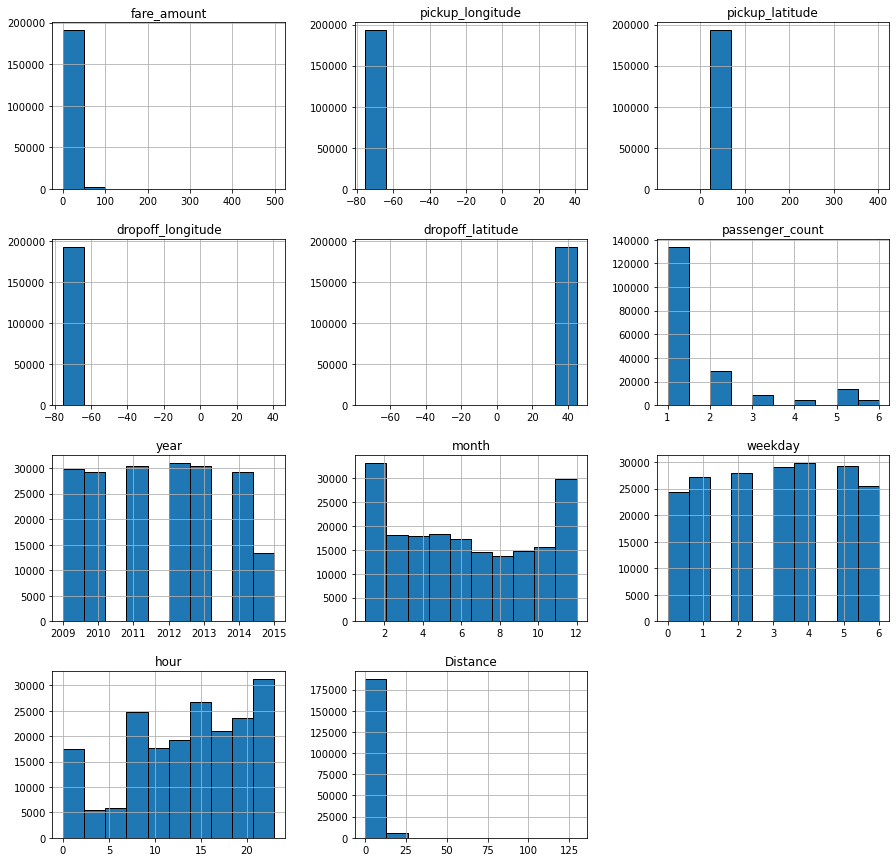

In [34]:
df.hist(figsize=(15,15), edgecolor = 'black');


Only month,hour follows a normal distribution

In [35]:
df.nunique().sort_values()


passenger_count           6
year                      7
weekday                   7
month                    12
hour                     24
fare_amount            1198
pickup_date            2372
pickup_longitude      70372
dropoff_longitude     76151
pickup_latitude       83144
dropoff_latitude      89839
pickup_time          167796
Distance             193209
dtype: int64

passenger_count,week_day and month are categorical

## Correlation Visualization



Correlation is a statistic that measures the degree to which two variables move with each other. A correlation coefficient near 1 indicates the strong relationship between them; a weak correlation indicates the extent to which one variable increases as the other decreases. Correlation among multiple variables can be represented in the form of a matrix. This allows us to see which variables are correlated.

In [36]:
corr = df.corr()


In [37]:
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Distance
fare_amount,1.000000,0.011723,-0.008344,0.010239,-0.008350,0.011902,0.120447,0.024138,0.006285,-0.020726,0.790204
pickup_longitude,0.011723,1.000000,-0.949081,0.999875,-0.993961,0.009664,0.013431,-0.007502,0.008242,0.001838,0.005115
pickup_latitude,-0.008344,-0.949081,1.000000,-0.949085,0.954748,-0.009741,-0.013684,0.007627,-0.008919,-0.001821,0.002948
dropoff_longitude,0.010239,0.999875,-0.949085,1.000000,-0.993947,0.009662,0.013327,-0.007469,0.008530,0.000946,0.004087
dropoff_latitude,-0.008350,-0.993961,0.954748,-0.993947,1.000000,-0.009782,-0.014338,0.008019,-0.008918,-0.001020,-0.002270
passenger_count,0.011902,0.009664,-0.009741,0.009662,-0.009782,1.000000,0.005334,0.008811,0.036308,0.014739,0.005610
year,0.120447,0.013431,-0.013684,0.013327,-0.014338,0.005334,1.000000,-0.115189,0.005963,0.001896,0.019258
month,0.024138,-0.007502,0.007627,-0.007469,0.008019,0.008811,-0.115189,1.000000,-0.009133,-0.004307,0.008092
weekday,0.006285,0.008242,-0.008919,0.008530,-0.008918,0.036308,0.005963,-0.009133,1.000000,-0.085949,0.016587
hour,-0.020726,0.001838,-0.001821,0.000946,-0.001020,0.014739,0.001896,-0.004307,-0.085949,1.000000,-0.027504


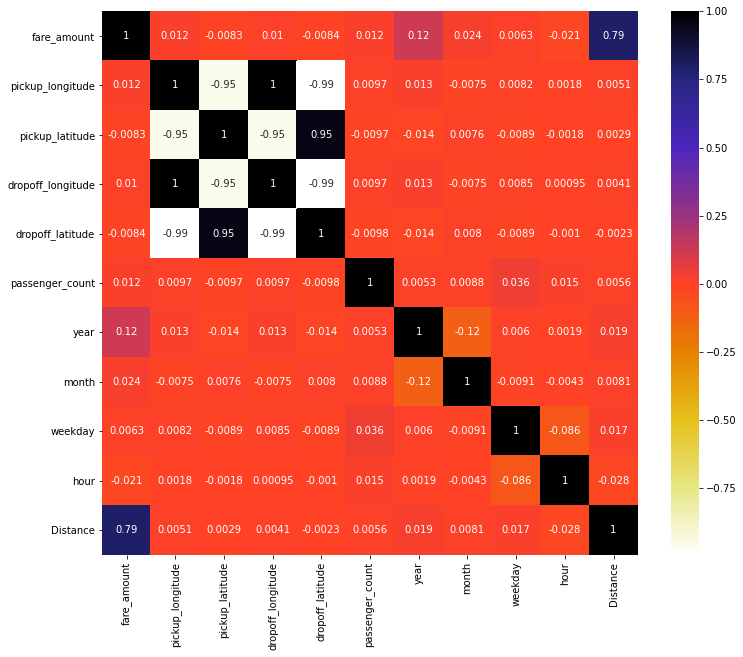

In [39]:
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [40]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()# Set of all the names of correlated columns
    vals =set()
    corr_matrix = df.corr()
    for i in range(0,len(corr_matrix.columns)):
        for j in range(0,i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


In [41]:
corr_features = correlation(df, 0.7)

In [42]:
corr_features


{'Distance', 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude'}

In [43]:
features = []
correlations = []
corr_matrix = df.corr()
for idx, correlation in corr_matrix['fare_amount'].T.iteritems():
    if correlation >= .30 and idx != 'fare_amount':
        features.append(idx)
        correlations.append(correlation)
corr_price_df = pd.DataFrame({'Correlations':correlations, 'Features': features}).sort_values(by=['Correlations'], ascending=False)


In [44]:
display("correlation with fare amount",corr_price_df)


'correlation with fare amount'

,Correlations,Features
0,0.790204,Distance


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193218 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        193218 non-null  float64
 1   pickup_longitude   193218 non-null  float64
 2   pickup_latitude    193218 non-null  float64
 3   dropoff_longitude  193218 non-null  float64
 4   dropoff_latitude   193218 non-null  float64
 5   passenger_count    193218 non-null  int64  
 6   pickup_date        193218 non-null  object 
 7   pickup_time        193218 non-null  object 
 8   year               193218 non-null  int64  
 9   month              193218 non-null  int64  
 10  weekday            193218 non-null  int64  
 11  hour               193218 non-null  int64  
 12  Distance           193218 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 20.6+ MB


To find the peak hours during weekdays.

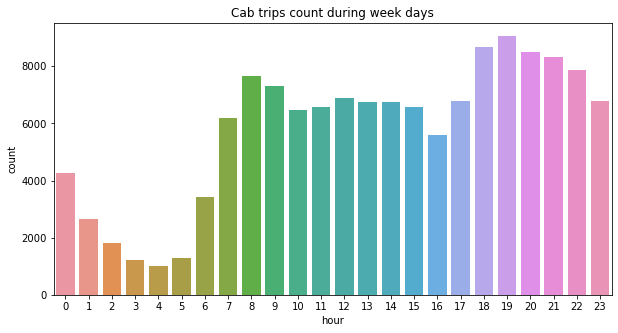

In [46]:
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week days')
sns.countplot(x='hour', data=df.loc[(df.weekday >= 0) & (df.weekday <=4)])
plt.show()

From the above plot we can infer that during weekdays the peak hours with maximum trips are 8am to 9am during the day and 6pm to 8pm during the night.

To find the fare amount during peak hours during week days

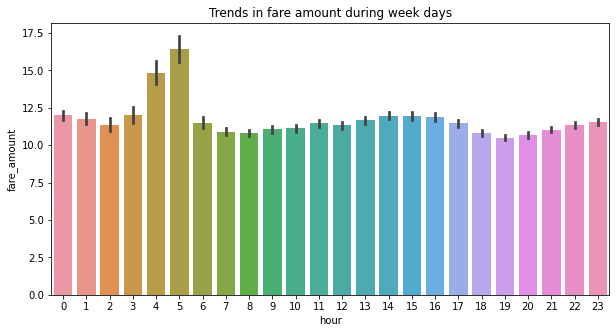

In [47]:
plt.figure(figsize=(10,5))
plt.title('Trends in fare amount during week days')
sns.barplot(x='hour',y='fare_amount' ,data=df.loc[(df.weekday >= 0) & (df.weekday <=4)])
plt.show()

From the above plot it is found that fare price is high only during early morning hours which is not a peak hour else it is uniform.

To find the peak hours during weekends.

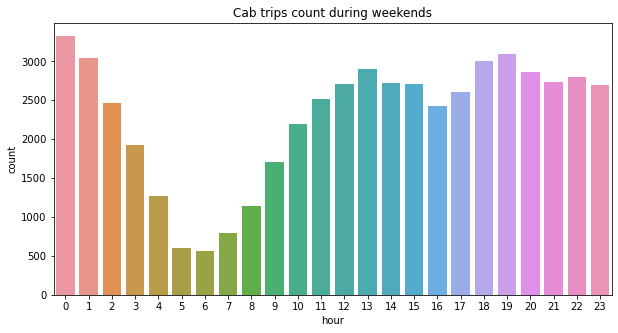

In [48]:
plt.figure(figsize=(10,5))
plt.title('Cab trips count during weekends')
sns.countplot(x='hour', data=df.loc[(df.weekday >= 5) & (df.weekday <=6)])
plt.show()

To find the fare amount during peak hours during weekends

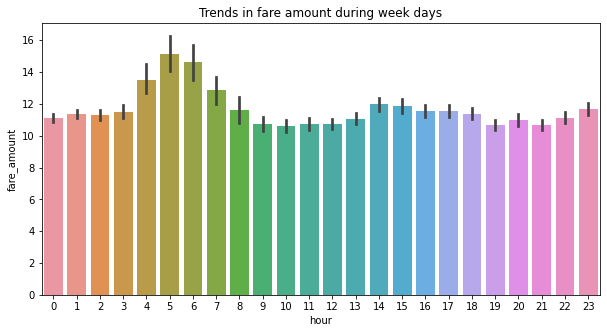

In [49]:
plt.figure(figsize=(10,5))
plt.title('Trends in fare amount during week days')
sns.barplot(x='hour',y='fare_amount' ,data=df.loc[(df.weekday >= 5) & (df.weekday <=6)])
plt.show()

From the above plots we can understand that the fare amount is high only during the non-peak hours.Thus hours is an important predictor.

## Distribution of key numeric variables

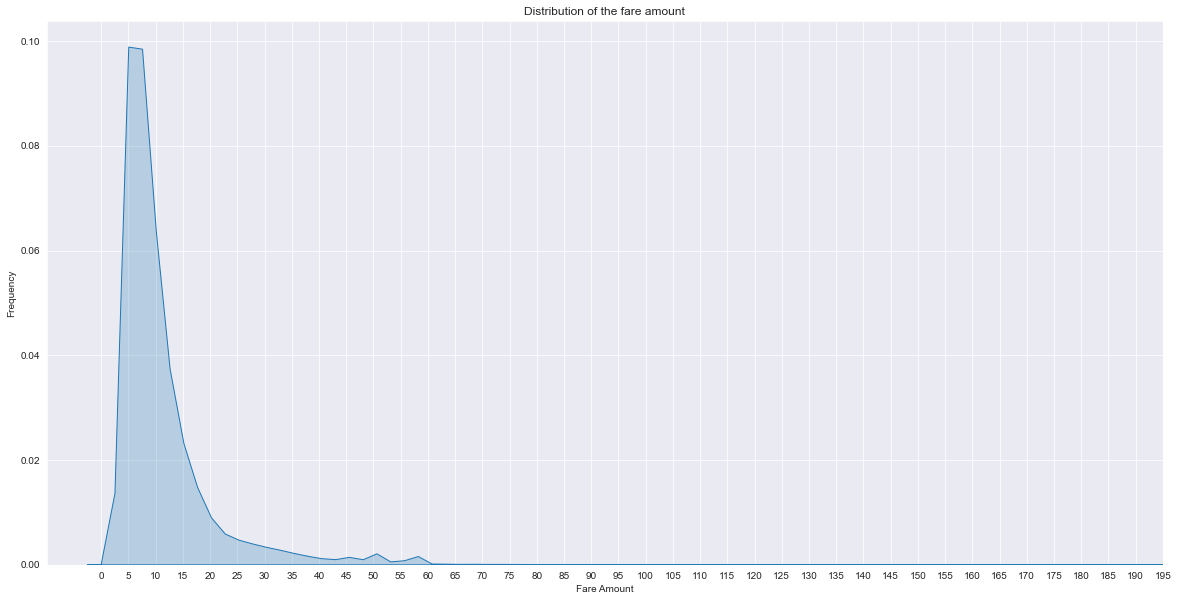

In [50]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df.fare_amount, shade=True)

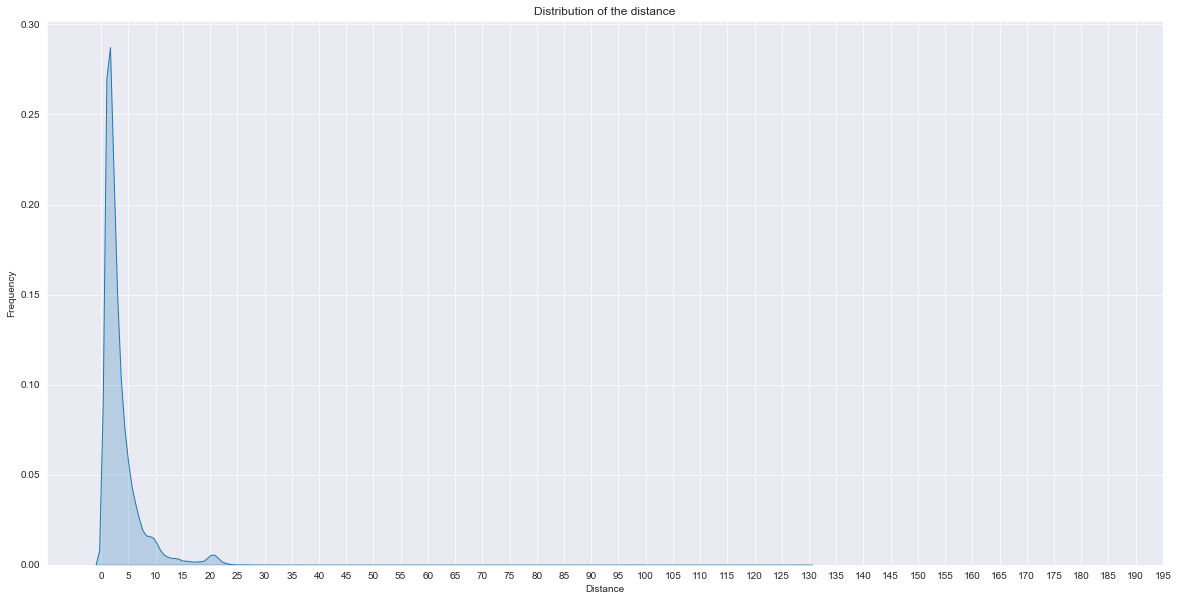

In [51]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df.Distance, shade=True)

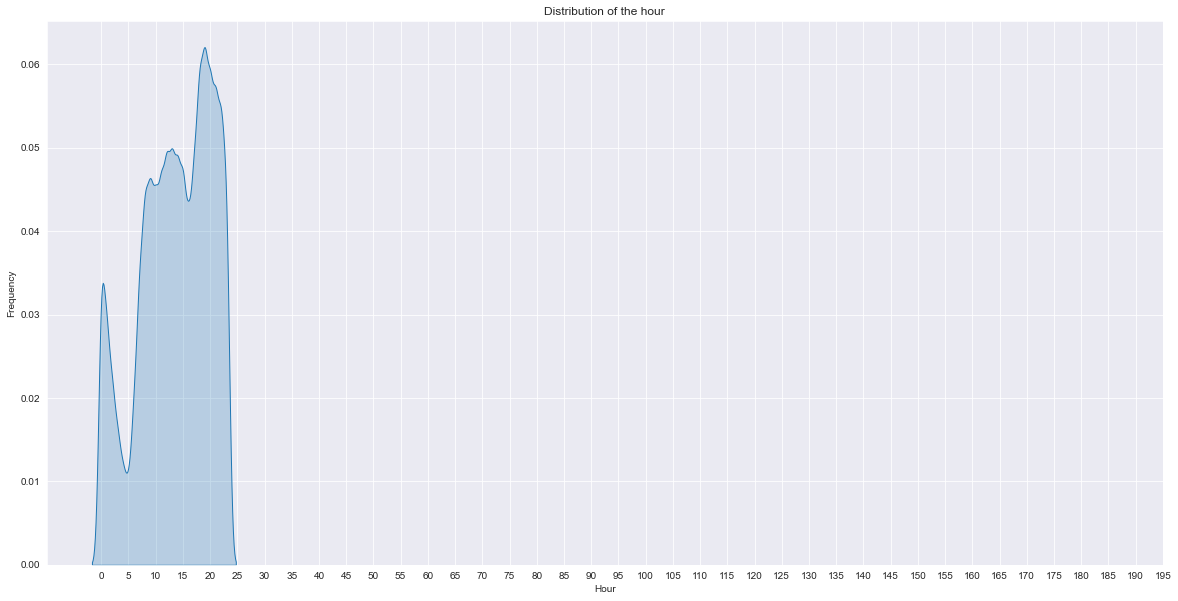

In [52]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the hour")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df.hour, shade=True)

## Categorical Variables

In [53]:
#creating dummy variables for month,weekday and passenger count
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
weekday_dummies = pd.get_dummies(df['weekday'], prefix='day', drop_first=True)
count_dummies = pd.get_dummies(df['passenger_count'], prefix='count', drop_first=True)

In [54]:
df = df.drop(['month','weekday','passenger_count'], axis=1)

In [55]:
df = pd.concat([df, month_dummies, weekday_dummies, count_dummies], axis=1)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_date,pickup_time,year,hour,Distance,...,day_2,day_3,day_4,day_5,day_6,count_2,count_3,count_4,count_5,count_6
0,7.5,-73.999817,40.738354,-73.999512,40.723217,2015-05-07,19:52:06.0000003,2015,19,1.683323,...,0,1,0,0,0,0,0,0,0,0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2009-07-17,20:04:56.0000002,2009,20,2.457590,...,0,0,1,0,0,0,0,0,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,2009-08-24,21:45:00.00000061,2009,21,5.036377,...,0,0,0,0,0,0,0,0,0,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,2009-06-26,08:22:21.0000001,2009,8,1.661683,...,0,0,1,0,0,0,1,0,0,0
4,16.0,-73.925023,40.744085,-73.973082,40.761247,2014-08-28,17:47:00.000000188,2014,17,4.475450,...,0,1,0,0,0,0,0,0,1,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193218 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        193218 non-null  float64
 1   pickup_longitude   193218 non-null  float64
 2   pickup_latitude    193218 non-null  float64
 3   dropoff_longitude  193218 non-null  float64
 4   dropoff_latitude   193218 non-null  float64
 5   year               193218 non-null  int64  
 6   hour               193218 non-null  int64  
 7   Distance           193218 non-null  float64
 8   month_2            193218 non-null  uint8  
 9   month_3            193218 non-null  uint8  
 10  month_4            193218 non-null  uint8  
 11  month_5            193218 non-null  uint8  
 12  month_6            193218 non-null  uint8  
 13  month_7            193218 non-null  uint8  
 14  month_8            193218 non-null  uint8  
 15  month_9            193218 non-null  uint8  
 16  mo

In [57]:
df= df.drop(['pickup_date','pickup_time'],axis=1)

KeyError: "['pickup_date' 'pickup_time'] not found in axis"

In [ ]:
#Dependent variable is 'fare_amount' and independent variables/predictors are the rest of variables as below: 

#y = pd.DataFrame(df['fare_amount'])
#x = df.drop('fare_amount',axis = 1)

In [ ]:
#x_cols = ['Distance','fare_amount','year','hour']

In [ ]:
#pd.plotting.scatter_matrix(df[x_cols], figsize=(10,12));


Log transformation of the non-normal variables -distance,year,fare amount

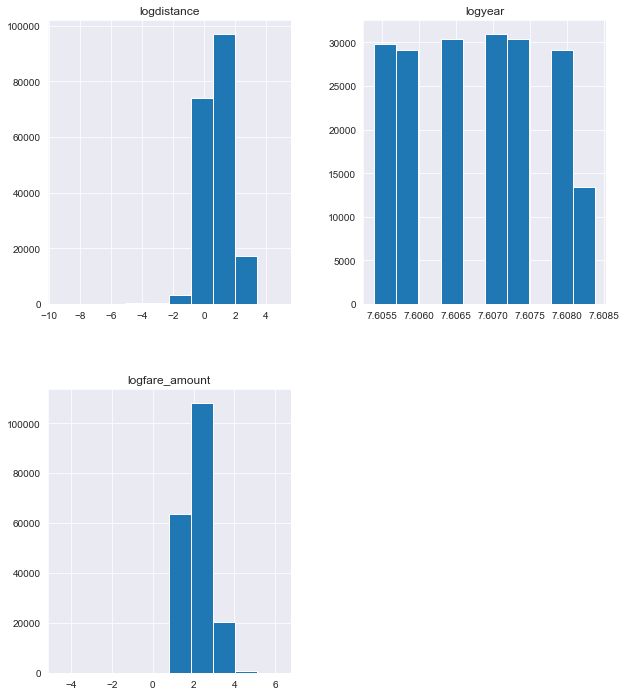

In [59]:
data_log = pd.DataFrame([])
data_log['logdistance'] = np.log(df['Distance'])
data_log['logyear'] =np.log(df['year'])
data_log['logfare_amount'] = np.log(df['fare_amount'])
data_log.hist(figsize  = [10,12]);

In [60]:
#Dependent variable is 'fare_amount' and independent variables/predictors are the rest of variables as below: 

y = pd.DataFrame(data_log['logfare_amount'])
x = df.drop(['Distance','fare_amount','year'],axis = 1)

In [61]:
x = x.join(data_log[['logdistance','logyear']])

## MULTIPLE REGRESSION


##  Model 1

In [62]:
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
model1 = sm.OLS(y, x).fit()
 
# printing the summary table
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         logfare_amount   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.058e+04
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:12:47   Log-Likelihood:                -83140.
No. Observations:              193218   AIC:                         1.663e+05
Df Residuals:                  193188   BIC:                         1.666e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -649.1495      7.06

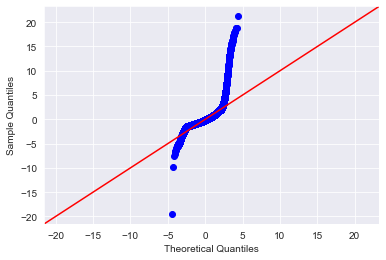

In [63]:
import scipy.stats as stats 
residuals = model1.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, )    
plt.show;

There seems to be multicollinearity.

In [65]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model1.resid)
list(zip(name, test))

[('Jarque-Bera', 22800893.561292782),
 ('Prob', 0.0),
 ('Skew', 4.4245379759151415),
 ('Kurtosis', 55.47703429483271)]

/Users/kunjiv/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


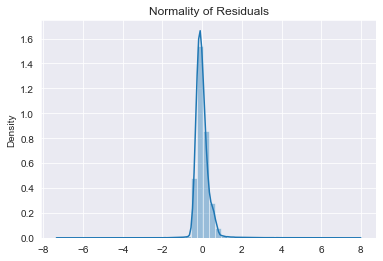

In [66]:
#Histogram of Residuals
sns.distplot(model1.resid) 
plt.title('Normality of Residuals')
plt.show()

## Model 2

Among the correlated variables {'Distance', 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude'},we may remove 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude' as distance is calculated from former two variables

In [67]:

x = df.drop(['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude'],axis = 1)

In [68]:
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
model2 = sm.OLS(y, x).fit()
 
# printing the summary table
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         logfare_amount   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 2.966e+04
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:14:07   Log-Likelihood:                -16751.
No. Observations:              193218   AIC:                         3.356e+04
Df Residuals:                  193190   BIC:                         3.384e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -30.5942      0.669  

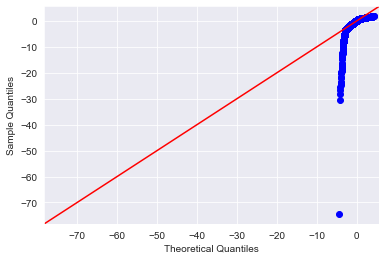

In [69]:
import scipy.stats as stats 
residuals = model2.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, )    
plt.show;

In [84]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model2.resid)
list(zip(name, test))

[('Jarque-Bera', 305384481.83292425),
 ('Prob', 0.0),
 ('Skew', -4.68639662711109),
 ('Kurtosis', 197.53682722240424)]

/Users/kunjiv/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


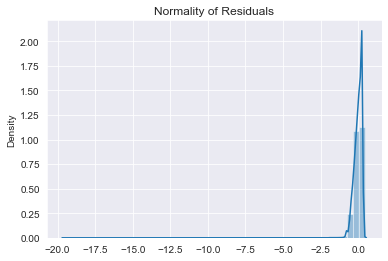

In [70]:
#Histogram of Residuals
sns.distplot(model2.resid) 
plt.title('Normality of Residuals')
plt.show()

Even though R2 is 0.806,the model is not satisfying normality so lets look into next model.

## Model 3

In [71]:
y = pd.DataFrame(data_log['logfare_amount'])
x = pd.DataFrame(data_log['logdistance'])
x = x.join(df['hour'])

In [72]:
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
model3 = sm.OLS(y, x).fit()
 
# printing the summary table
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:         logfare_amount   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                 1.409e+05
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:16:08   Log-Likelihood:                -88107.
No. Observations:              193218   AIC:                         1.762e+05
Df Residuals:                  193215   BIC:                         1.763e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.8296      0.002    854.810      

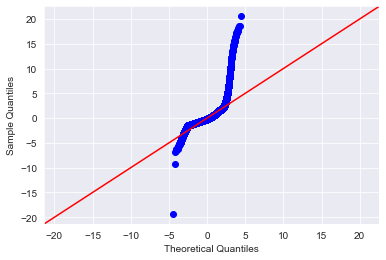

In [73]:
import scipy.stats as stats 
residuals = model3.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, )    
plt.show;

Normality Check (Jarque-Bera Test)
The Jarque-Bera (JB) test is a test for normality. This test is usually used for large data sets, because other tests like Q-Q Plots can become unreliable when your sample size is large.

In [74]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model3.resid)
list(zip(name, test))

[('Jarque-Bera', 18549336.934067406),
 ('Prob', 0.0),
 ('Skew', 4.125842356489469),
 ('Kurtosis', 50.28594393610232)]

/Users/kunjiv/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


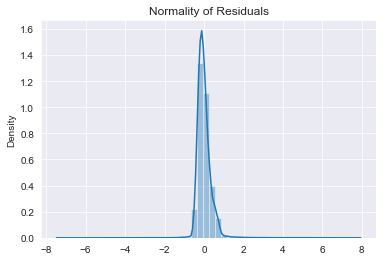

In [75]:
#Histogram of Residuals
sns.distplot(model3.resid) 
plt.title('Normality of Residuals')
plt.show()

The QQ plot is not having satifactory linear plot which might be due to skewed data.

## Validating the Model


In [76]:
from sklearn.model_selection import train_test_split


In [77]:
# split data into train subset and test subset for predictor and target variables
# 'test_size' returns the proportion of data to be included in the test set
# set 'random_state' to generate the same dataset each time you run the code 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

# check the dimensions of the train & test subset for 
# print dimension of predictors train set
print("The shape of X_train is:",x_train.shape)

# print dimension of predictors test set
print("The shape of X_test is:",x_test.shape)

# print dimension of target train set
print("The shape of y_train is:",y_train.shape)

# print dimension of target test set
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (154574, 3)
The shape of X_test is: (38644, 3)
The shape of y_train is: (154574, 1)
The shape of y_test is: (38644, 1)


In [78]:
# Import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [79]:
linreg.fit(x_train, y_train)


LinearRegression()

In [80]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


LinearRegression()

In [81]:
y_hat_train = linreg.predict(x_train)
y_hat_test = linreg.predict(x_test)

In [82]:

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [83]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)


Train Mean Squarred Error: 0.1469148176444233
Test Mean Squarred Error: 0.14109311700096908


The Mean Squarred Error for the train and test subsets are similar. This suggests that the model will perform similarly on different data.

Distance,hour are the best fit for a multiple regression model. These features are highly correlated with fare amount, have relatively low multicollinearity, and can together account for more than half of the variability of price. All multiple regression assumptions are satisfied with these features included.